# Regression Modeling

_by Anna Funsten_

### Contents:
 - [Import and Set up Data](#Import-and-Set-up-Data)
 - [Null Model ](#Null-Model)
 - [Model 1: Linear Regression ](#Model_1:_Linear_Regression)
 - [Model 2: Linear Regression with RFE](#Model_2:_Linear_Regression_with_RFE)
 - [Model 3: RFE and Ridge](#Model_3:_RFE_and_Ridge)
 - [Model 4: Lasso with RFE](#Model_4:_Lasso_with_RFE)
 - [Model 5: ElasticNet with RFE](#Model_5:_ElasticNet_with_RFE)
 - [Model 6: Linear Regression with Limited Features](#Model_6:_Linear_Regression_with_Limited_Features)
 - [Model 7: Elastic Net with Limited Features](#Model_7:_Elastic_Net_with_Limited_Features)
 - [Model 8: Lasso with Limited Features ](#Model_8:_Lasso_with_Limited_Features)
 - [Model 9: Ridge with Limited Features](#Model_9:_Ridge_with_Limited_Features)
 - [Model 10: KNN Regressor](#Model_10:_KNN_Regressor)
 - [Model 11: Simple Neural Networks](#Model_11:_Simple_Neural_Networks)
 - [Model 12: Best Model: Neural Networks adding Layers and Early Stopping](#Model_12:_Best_Model:_Neural_Networks_adding_Layers_and_Early_Stopping)
 - [Model 13: Decision Tree Regressor](#Model_13:_Decision_Tree_Regressor)
 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
from sklearn.tree import plot_tree
from sklearn.dummy import DummyRegressor

## Import and Set up Data
[(back to top)](#Regression-Modeling)

In [2]:
df = pd.read_csv('../data/cleaned_aqi_and_temp_data_2017-2019.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            1093 non-null   object 
 1   co_max          1062 non-null   float64
 2   co_aqi_val      1062 non-null   float64
 3   no2_max         1038 non-null   float64
 4   no2_aqi_val     1038 non-null   float64
 5   ozone_max       1057 non-null   float64
 6   ozone_aqi_val   1057 non-null   float64
 7   pm10_mean       1050 non-null   float64
 8   pm10_aqi_val    1050 non-null   float64
 9   pm2.5_mean      980 non-null    float64
 10  pm2.5_aqi_val   980 non-null    float64
 11  so2_max         1073 non-null   float64
 12  so2_aqi_val     1073 non-null   float64
 13  cumulative_aqi  1093 non-null   float64
 14  temp_high       1093 non-null   int64  
 15  temp_low        1093 non-null   int64  
 16  temp_avg        1093 non-null   float64
 17  pct_change_aqi  1092 non-null   f

In [4]:
df["weekday"] = df["weekday"].astype("category")

df["month"] = df["month"].astype("category")

df['date'] = pd.to_datetime(df['date'])

df.drop('pct_change_aqi', axis = 1, inplace = True)

df.set_index('date', inplace = True)

df.head()

In [10]:
X = df.drop('cumulative_aqi', axis =1 )
y = df['cumulative_aqi']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
def errors(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared = False)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return (f'root mean sqaured error is {rmse}, r squared is {r2}, and mean absolute error is {mae}')

## Null Model 
[(back to top)](#Regression-Modeling)

In [13]:
dr = DummyRegressor()
dummy = dr.fit(X_train, y_train)
dummy.score(X_test, y_test)

-0.0010034478432814353

In [14]:
null_preds = dummy.predict(X_test)

In [15]:
errors(y_test, null_preds)

'root mean sqaured error is 16.30190016159435, r squared is -0.0010034478432814353, and mean absolute error is 12.967438482037021'

## Model 1: Linear Regression 
[(back to top)](#Regression-Modeling)

In [16]:
pipe1 = make_pipeline(KNNImputer(), StandardScaler(), LinearRegression())

In [17]:
pipe1.fit(X_train, y_train)

Pipeline(steps=[('knnimputer', KNNImputer()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [18]:
cross_val_score(pipe1, X_train, y_train)

array([0.77883874, 0.84949753, 0.8118787 , 0.8930021 , 0.80329443])

In [19]:
predict1 = pipe1.predict(X_test)

In [20]:
errors(y_test, predict1)

'root mean sqaured error is 8.273884832259142, r squared is 0.7421435150091555, and mean absolute error is 5.113442409363419'

In [21]:
coef = pipe1.named_steps['linearregression'].coef_

name = X_train.columns

importance = pd.DataFrame(zip(name, coef), columns=['name', 'coef']).sort_values(by='coef', ascending=False)
importance

,name,coef
10,so2_max,26.744533
8,pm2.5_mean,16.318176
5,ozone_aqi_val,12.807527
6,pm10_mean,7.397730
2,no2_max,2.758968
1,co_aqi_val,0.617038
16,weekday,0.463985
13,temp_low,0.408921
14,temp_avg,-0.253013
15,month,-0.699771


## Model 2: Linear Regression with RFE
[(back to top)](#Regression-Modeling)

In [22]:
pipe2 = make_pipeline(KNNImputer(),StandardScaler(), RFE(estimator=LinearRegression()), LinearRegression())
params = {'rfe__n_features_to_select': [15, 10, 8, 5]}
gs2 = GridSearchCV(pipe2, params, n_jobs=1)
gs2.fit(X_train, y_train)
print(gs2.score(X_train, y_train))
print(gs2.score(X_test, y_test))
predict2 = gs2.predict(X_test)
errors(y_test, predict2)

0.8443830469560255
0.7411360649926647


'root mean sqaured error is 8.290032185533205, r squared is 0.7411360649926647, and mean absolute error is 5.108872326146265'

In [23]:
gs2.best_params_

{'rfe__n_features_to_select': 15}

In [24]:
coef = gs2.best_estimator_['linearregression'].coef_
name = X_train.columns
importance = pd.DataFrame(zip(name, coef), columns=['name', 'coef']).sort_values(by='coef', ascending=False)
importance

,name,coef
10,so2_max,26.908209
8,pm2.5_mean,16.324416
5,ozone_aqi_val,12.819200
6,pm10_mean,7.440145
2,no2_max,2.787315
1,co_aqi_val,0.586277
14,temp_avg,0.458875
12,temp_high,-0.682199
13,temp_low,-0.683036
0,co_max,-0.935702


## Model 3: RFE and Ridge 
[(back to top)](#Regression-Modeling)

In [25]:
pipe3 = make_pipeline(KNNImputer(),StandardScaler(), RFE(estimator=LinearRegression()), Ridge())
params = {'rfe__n_features_to_select': [17, 15, 10, 8, 5],
          'ridge__alpha': [.01, .1 ,1 ,10 ,100, 1000]}
gs3 = GridSearchCV(pipe3, params, n_jobs=1)
gs3.fit(X_train, y_train)
print(gs3.score(X_train, y_train))
print(gs3.score(X_test, y_test))
predict3 = gs3.predict(X_test)
print(errors(y_test, predict3))
gs3.best_params_

0.844311554940499
0.7733280961955067
root mean sqaured error is 7.757455419966234, r squared is 0.7733280961955067, and mean absolute error is 5.032271954725555


{'rfe__n_features_to_select': 17, 'ridge__alpha': 0.1}

In [26]:
coef = gs3.best_estimator_['ridge'].coef_
name = X_train.columns
importance = pd.DataFrame(zip(name, coef), columns=['name', 'coef']).sort_values(by='coef', ascending=False)
importance

,name,coef
10,so2_max,22.768656
8,pm2.5_mean,16.262367
5,ozone_aqi_val,12.750437
6,pm10_mean,6.957920
2,no2_max,1.980383
1,co_aqi_val,0.604951
13,temp_low,0.449942
16,weekday,0.449480
14,temp_avg,-0.255853
15,month,-0.699570


## Model 4: Lasso with RFE
[(back to top)](#Regression-Modeling)

In [27]:
pipe4 = make_pipeline(KNNImputer(),StandardScaler(), RFE(estimator=LinearRegression()), Lasso())
params = {'rfe__n_features_to_select': [17, 15, 10, 8, 5],
          'lasso__alpha': [.01, .1 ,1 ,10 ,100, 1000]}
gs4 = GridSearchCV(pipe4, params, n_jobs=1)
gs4.fit(X_train, y_train)
print(gs4.score(X_train, y_train))
print(gs4.score(X_test, y_test))
predict4 = gs4.predict(X_test)
print(errors(y_test, predict4))
gs4.best_params_

/Users/annafunsten/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1215.077368529146, tolerance: 14.151416793893134
  model = cd_fast.enet_coordinate_descent(
/Users/annafunsten/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 495.28249565581064, tolerance: 14.466252519083973
  model = cd_fast.enet_coordinate_descent(
/Users/annafunsten/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1641.9878378606427, tolerance: 14.412267786259543
  model = cd_fast.enet_coordinate_descent(
/Users/annafunsten/opt/anaconda3/lib/python3.8/sit

0.841902149115362
0.8242945031363862
root mean sqaured error is 6.829880681065509, r squared is 0.8242945031363862, and mean absolute error is 4.817008216033618


/Users/annafunsten/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1104.1417241560848, tolerance: 17.676049328449327
  model = cd_fast.enet_coordinate_descent(


{'lasso__alpha': 0.01, 'rfe__n_features_to_select': 17}

In [28]:
coef = gs4.best_estimator_['lasso'].coef_
name = X_train.columns
importance = pd.DataFrame(zip(name, coef), columns=['name', 'coef']).sort_values(by='coef', ascending=False)
importance

,name,coef
8,pm2.5_mean,15.833849
5,ozone_aqi_val,12.379038
10,so2_max,9.494319
6,pm10_mean,2.106374
16,weekday,0.408611
2,no2_max,0.398286
13,temp_low,0.247656
3,no2_aqi_val,0.000000
1,co_aqi_val,0.000000
14,temp_avg,-0.000000


## Model 5: ElasticNet with RFE
[(back to top)](#Regression-Modeling)

In [29]:
pipe5 = make_pipeline(KNNImputer(),StandardScaler(), RFE(estimator=LinearRegression()), ElasticNet())
params = {'rfe__n_features_to_select': [17, 15, 10, 8, 5],
          'elasticnet__alpha': [.01, .1 ,1 ,10 ,100, 1000],
          'elasticnet__l1_ratio': [0, .2, .4 , .6, .8, 1]
         }
gs5 = GridSearchCV(pipe5, params, n_jobs=1)
gs5.fit(X_train, y_train)
print(gs5.score(X_train, y_train))
print(gs5.score(X_test, y_test))
predict5 = gs5.predict(X_test)
print(errors(y_test, predict5))
gs5.best_params_

/Users/annafunsten/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12082.51482082823, tolerance: 14.151416793893134
  model = cd_fast.enet_coordinate_descent(
/Users/annafunsten/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13142.543852570685, tolerance: 14.466252519083973
  model = cd_fast.enet_coordinate_descent(
/Users/annafunsten/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12256.169619126067, tolerance: 14.412267786259543
  model = cd_fast.enet_coordinate_descent(
/Users/annafunsten/opt/anaconda3/lib/python3.8/sit

0.841902149115362
0.8242945031363862
root mean sqaured error is 6.829880681065509, r squared is 0.8242945031363862, and mean absolute error is 4.817008216033618


/Users/annafunsten/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1104.1417241560848, tolerance: 17.676049328449327
  model = cd_fast.enet_coordinate_descent(


{'elasticnet__alpha': 0.01,
 'elasticnet__l1_ratio': 1,
 'rfe__n_features_to_select': 17}

In [30]:
coef = gs5.best_estimator_['elasticnet'].coef_

name = X_train.columns
importance = pd.DataFrame(zip(name, coef), columns=['name', 'coef']).sort_values(by='coef', ascending=False)
importance

,name,coef
8,pm2.5_mean,15.833849
5,ozone_aqi_val,12.379038
10,so2_max,9.494319
6,pm10_mean,2.106374
16,weekday,0.408611
2,no2_max,0.398286
13,temp_low,0.247656
3,no2_aqi_val,0.000000
1,co_aqi_val,0.000000
14,temp_avg,-0.000000


## Model 6: Linear Regression with Limited Features
[(back to top)](#Regression-Modeling)

to reduce mulitcolinearity will take out readings for each pollutant AQI, and low and high temp.

In [31]:
X = df.drop(columns = ['cumulative_aqi', 'temp_high', 'temp_low', 'co_aqi_val', 'no2_aqi_val', 'pm10_aqi_val', 'pm2.5_aqi_val', 'so2_aqi_val', 'ozone_aqi_val'])
y = df['cumulative_aqi']

In [32]:
X

,co_max,no2_max,ozone_max,pm10_mean,pm2.5_mean,so2_max,temp_avg,month,weekday
date,,,,,,,,,
2017-01-01,0.5,36.0,0.026,21.0,9.6,5.0,35.0,1,6
2017-01-02,0.5,33.0,0.009,18.0,14.1,2.0,42.0,1,0
2017-01-03,0.4,24.0,0.015,9.0,7.7,0.0,45.0,1,1
2017-01-04,0.2,NaN,0.027,19.0,4.6,0.0,30.0,1,2
2017-01-05,NaN,19.0,0.020,11.0,5.3,0.0,17.0,1,3
...,...,...,...,...,...,...,...,...,...
2019-12-27,0.2,9.0,0.022,14.0,11.3,0.0,50.5,12,4
2019-12-28,0.4,24.0,0.016,19.0,20.9,1.0,42.0,12,5
2019-12-29,0.4,12.0,0.018,20.0,13.7,1.0,50.0,12,6


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [34]:
pipe6 = make_pipeline(KNNImputer(), StandardScaler(), LinearRegression())

In [35]:
pipe6.fit(X_train, y_train)

Pipeline(steps=[('knnimputer', KNNImputer()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [36]:
cross_val_score(pipe6, X_train, y_train)

array([0.83443668, 0.71303178, 0.71037071, 0.78551196, 0.78701554])

In [37]:
predict6 = pipe6.predict(X_test)

In [38]:
errors(y_test, predict6)

'root mean sqaured error is 7.133285417833726, r squared is 0.7897587432870873, and mean absolute error is 4.824681289540676'

In [39]:
coef = pipe6.named_steps['linearregression'].coef_

name = X_train.columns

importance = pd.DataFrame(zip(name, coef), columns=['name', 'coef']).sort_values(by='coef', ascending=False)
importance

,name,coef
4,pm2.5_mean,11.800052
2,ozone_max,4.690606
5,so2_max,0.796627
1,no2_max,0.333931
0,co_max,0.322005
8,weekday,0.082475
3,pm10_mean,-0.118835
7,month,-0.177612
6,temp_avg,-0.986281


## Model 7: Elastic Net with Limited Features 
[(back to top)](#Regression-Modeling)

In [40]:
pipe7 = make_pipeline(KNNImputer(),StandardScaler(), ElasticNet())
params = {'elasticnet__alpha': [.01, .1 ,1 ,10 ,100, 1000],
          'elasticnet__l1_ratio': [0, .2, .4 , .6, .8, 1]
         }
gs7 = GridSearchCV(pipe7, params, n_jobs=1)
gs7.fit(X_train, y_train)
print(gs7.score(X_train, y_train))
print(gs7.score(X_test, y_test))
predict7 = gs7.predict(X_test)
print(errors(y_test, predict7))
gs7.best_params_

/Users/annafunsten/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17248.06620486703, tolerance: 14.195571908396946
  model = cd_fast.enet_coordinate_descent(
/Users/annafunsten/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15858.942218412378, tolerance: 14.874802137404583
  model = cd_fast.enet_coordinate_descent(
/Users/annafunsten/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17032.794211322314, tolerance: 15.281971908396946
  model = cd_fast.enet_coordinate_descent(
/Users/annafunsten/opt/anaconda3/lib/python3.8/sit

0.7796245970713171
0.7885974799636769
root mean sqaured error is 7.15295856794875, r squared is 0.7885974799636769, and mean absolute error is 4.818578670186391


{'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 1}

In [41]:
gs5.best_estimator_['elasticnet'].coef_

array([-0.41977994,  0.        ,  0.398286  ,  0.        , -7.86690624,
       12.37903831,  2.10637418, -1.78565357, 15.83384936, -4.26256524,
        9.49431913, -7.78109457, -0.96599281,  0.24765554, -0.        ,
       -0.67296007,  0.4086108 ])

## Model 8: Lasso with Limited Features 

In [42]:
pipe8 = make_pipeline(KNNImputer(),StandardScaler(), Lasso())
params = {'lasso__alpha': [.01, .1 ,1 ,10 ,100, 1000]}
gs8 = GridSearchCV(pipe8, params, n_jobs=1)
gs8.fit(X_train, y_train)
print(gs8.score(X_train, y_train))
print(gs8.score(X_test, y_test))
predict8 = gs8.predict(X_test)
print(errors(y_test, predict8))
gs8.best_params_

0.7796245970713171
0.7885974799636769
root mean sqaured error is 7.15295856794875, r squared is 0.7885974799636769, and mean absolute error is 4.818578670186391


{'lasso__alpha': 0.1}

In [43]:
coef = gs8.best_estimator_['lasso'].coef_
name = X_train.columns
importance = pd.DataFrame(zip(name, coef), columns=['name', 'coef']).sort_values(by='coef', ascending=False)
importance

,name,coef
4,pm2.5_mean,11.722964
2,ozone_max,4.483731
5,so2_max,0.691392
1,no2_max,0.300265
0,co_max,0.248786
8,weekday,0.002331
3,pm10_mean,0.000000
7,month,-0.155746
6,temp_avg,-0.809063


## Model 9: Ridge with Limited Features
[(back to top)](#Regression-Modeling)

In [44]:
pipe9 = make_pipeline(KNNImputer(),StandardScaler(), Ridge())
params = {'ridge__alpha': [.01, .1 ,1 ,10 ,100, 1000]}
gs9 = GridSearchCV(pipe9, params, n_jobs=1)
gs9.fit(X_train, y_train)
print(gs9.score(X_train, y_train))
print(gs9.score(X_test, y_test))
predict9 = gs9.predict(X_test)
print(errors(y_test, predict9))
gs9.best_params_

0.7797634250491456
0.7886021280779962
root mean sqaured error is 7.152879931346176, r squared is 0.7886021280779962, and mean absolute error is 4.847503556417131


{'ridge__alpha': 10}

In [45]:
coef = gs9.best_estimator_['ridge'].coef_
name = X_train.columns
importance = pd.DataFrame(zip(name, coef), columns=['name', 'coef']).sort_values(by='coef', ascending=False)
importance

,name,coef
4,pm2.5_mean,11.547316
2,ozone_max,4.569004
5,so2_max,0.748713
0,co_max,0.386920
1,no2_max,0.339159
8,weekday,0.115608
3,pm10_mean,0.048991
7,month,-0.198329
6,temp_avg,-0.967276


## Model 10: KNN Regressor
[(back to top)](#Regression-Modeling)

In [46]:
pipe10 = make_pipeline(KNNImputer(),StandardScaler(), KNeighborsRegressor())
params = {'kneighborsregressor__n_neighbors': [3,5,10]}
gs10 = GridSearchCV(pipe10, params, n_jobs=1)
gs10.fit(X_train, y_train)
print(gs10.score(X_train, y_train))
print(gs10.score(X_test, y_test))
predict10 = gs10.predict(X_test)
print(errors(y_test, predict10))
gs10.best_params_

0.8575264756941775
0.7709339014101684
root mean sqaured error is 7.445794384388985, r squared is 0.7709339014101684, and mean absolute error is 5.00948905109489


{'kneighborsregressor__n_neighbors': 5}

## Model 11: Simple Neural Networks
[(back to top)](#Regression-Modeling)

In [47]:
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

knn = KNNImputer()

X_train_knn = knn.fit_transform(X_train_scaled)

X_test_knn = knn.transform(X_test_scaled)

In [48]:
model11 = Sequential()
model11.add(Dense(24, activation = 'relu'))
model11.add(Dense(1,))
model11.compile(optimizer = 'adam', loss='mse', metrics = ['mse'])

In [49]:
model11.compile(optimizer = 'adam', loss='mse', metrics = ['mse'])

In [50]:
history11 = model11.fit(
    X_train_knn,
    y_train,
    batch_size = 100,
    validation_data=(X_test_knn, y_test),
    epochs= 100,
)

Epoch 1/100
9/9 [==============================] - 2s 149ms/step - loss: 2021.5027 - mse: 2021.5027 - val_loss: 2142.6870 - val_mse: 2142.6870
Epoch 2/100
9/9 [==============================] - 0s 8ms/step - loss: 1928.0007 - mse: 1928.0007 - val_loss: 2127.9351 - val_mse: 2127.9351
Epoch 3/100
9/9 [==============================] - 0s 8ms/step - loss: 1958.3898 - mse: 1958.3898 - val_loss: 2112.6221 - val_mse: 2112.6221
Epoch 4/100
9/9 [==============================] - 0s 7ms/step - loss: 1967.3075 - mse: 1967.3076 - val_loss: 2097.3157 - val_mse: 2097.3157
Epoch 5/100
9/9 [==============================] - 0s 9ms/step - loss: 1930.9632 - mse: 1930.9632 - val_loss: 2081.9380 - val_mse: 2081.9380
Epoch 6/100
9/9 [==============================] - 0s 10ms/step - loss: 1892.1543 - mse: 1892.1543 - val_loss: 2065.9431 - val_mse: 2065.9431
Epoch 7/100
9/9 [==============================] - 0s 9ms/step - loss: 1930.9931 - mse: 1930.9931 - val_loss: 2049.6475 - val_mse: 2049.6475
Epoch 8/10

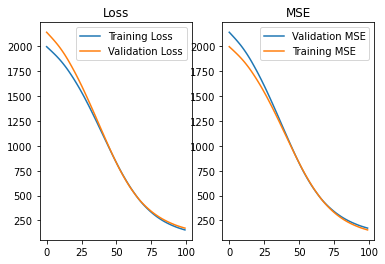

In [51]:
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history11.history['loss'], label = 'Training Loss')
plt.plot(history11.history['val_loss'], label = 'Validation Loss')
plt.legend();

plt.subplot(1, 2, 2)
plt.title('MSE')
plt.plot(history11.history['val_mse'], label = 'Validation MSE')
plt.plot(history11.history['mse'], label = 'Training MSE')
plt.legend();

In [52]:
preds11 = model11.predict(X_test_knn)

In [53]:
errors(y_test, preds11)

'root mean sqaured error is 13.138489547425452, r squared is 0.2867699694940702, and mean absolute error is 10.580571877695348'

## Model 12: Best Model: Neural Networks adding Layers and Early Stopping
[(back to top)](#Regression-Modeling)

In [54]:
model12 = Sequential()
model12.add(Dense(50, activation = 'relu'))
model12.add(Dense(200, activation = 'relu'))
model12.add(Dense(50, activation = 'relu'))
model12.add(Dense(50, activation = 'relu'))
model12.add(Dense(1,))

model12.compile(optimizer = 'adam', loss='mse', metrics = ['mse'])
early_stop = EarlyStopping(patience = 5) 
history12 = model12.fit(
    X_train_knn,
    y_train,
    batch_size = 100,
    callbacks = [early_stop],
    validation_data=(X_test_knn, y_test),
    epochs= 100
)

Epoch 1/100
9/9 [==============================] - 1s 37ms/step - loss: 1996.3625 - mse: 1996.3625 - val_loss: 2077.0623 - val_mse: 2077.0623
Epoch 2/100
9/9 [==============================] - 0s 10ms/step - loss: 1847.5795 - mse: 1847.5795 - val_loss: 1796.2268 - val_mse: 1796.2268
Epoch 3/100
9/9 [==============================] - 0s 9ms/step - loss: 1507.2852 - mse: 1507.2852 - val_loss: 1180.9486 - val_mse: 1180.9486
Epoch 4/100
9/9 [==============================] - 0s 11ms/step - loss: 936.8638 - mse: 936.8638 - val_loss: 338.2797 - val_mse: 338.2797
Epoch 5/100
9/9 [==============================] - 0s 8ms/step - loss: 247.8311 - mse: 247.8311 - val_loss: 379.0016 - val_mse: 379.0016
Epoch 6/100
9/9 [==============================] - 0s 8ms/step - loss: 279.6535 - mse: 279.6535 - val_loss: 166.4599 - val_mse: 166.4599
Epoch 7/100
9/9 [==============================] - 0s 8ms/step - loss: 132.1919 - mse: 132.1919 - val_loss: 140.4067 - val_mse: 140.4067
Epoch 8/100
9/9 [=========

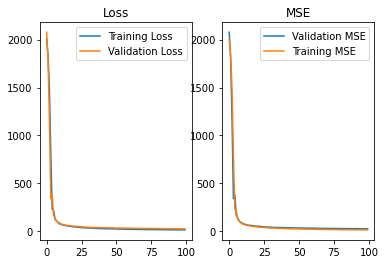

In [55]:
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history12.history['loss'], label = 'Training Loss')
plt.plot(history12.history['val_loss'], label = 'Validation Loss')
plt.legend();

plt.subplot(1, 2, 2)
plt.title('MSE')
plt.plot(history12.history['val_mse'], label = 'Validation MSE')
plt.plot(history12.history['mse'], label = 'Training MSE')
plt.legend();

from the loss and MSE graphs we can see that the data is not over fit with training and validation

In [56]:
pred12 = model12.predict(X_test_knn)

In [57]:
errors(y_test, pred12)

'root mean sqaured error is 4.984972898905565, r squared is 0.8973250868352323, and mean absolute error is 3.2106938396927216'

Overall, this was the best performing model with the lowest mean squared error and r2

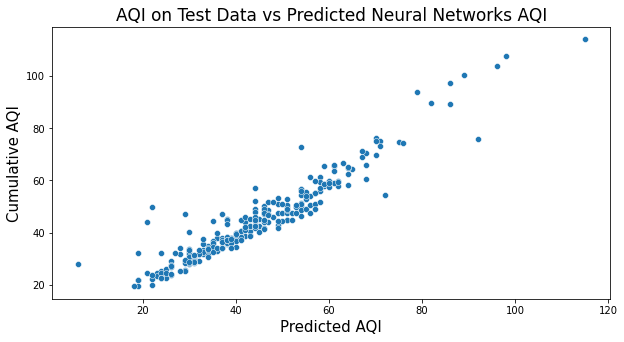

In [58]:
plt.subplots(figsize = (10,5))
plt.title('AQI on Test Data vs Predicted Neural Networks AQI', fontsize = 17)
plt.xlabel('Predicted AQI', fontsize = 15)
plt.ylabel('Cumulative AQI', fontsize = 15)
sns.scatterplot(x = y_test, y = pred12[:, 0]);

Predicted and actual AQI values are aligning well

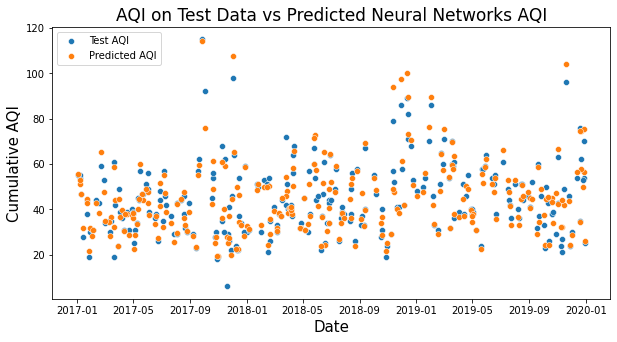

In [59]:
plt.subplots(figsize = (10,5))
plt.title('AQI on Test Data vs Predicted Neural Networks AQI', fontsize = 17)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Cumulative AQI', fontsize = 15)
sns.scatterplot(x = y_test.index, y = y_test, label = 'Test AQI');
sns.scatterplot(x = y_test.index, y = pred12[:, 0], label = 'Predicted AQI');

Test AQI values in blue align very well with the predicted aqi values displayed in orange from our model

## Model 13: Decision Tree Regressor
[(back to top)](#Regression-Modeling)

In [60]:
pipe13 = make_pipeline(KNNImputer(),StandardScaler(), DecisionTreeRegressor())

params13 = {
'decisiontreeregressor__max_depth': [2,5,9]}

gs_tree13 = GridSearchCV(pipe13, params13, n_jobs =-1)

gs_tree13.fit(X_train, y_train)
print(gs_tree13.score(X_train, y_train))
print(gs_tree13.score(X_test, y_test))
gs_tree13.best_params_

0.914887638548119
0.7863121677194889


{'decisiontreeregressor__max_depth': 5}

In [61]:
pred13 = gs_tree13.predict(X_test)

In [62]:
errors(y_test, pred13)

'root mean sqaured error is 7.191517244827711, r squared is 0.7863121677194889, and mean absolute error is 3.3112889247049813'

Decision tree second best model with second best r2 and msme

In [63]:
importance = gs_tree13.best_estimator_['decisiontreeregressor'].feature_importances_
name = X_train.columns
importance = pd.DataFrame(zip(name, importance), columns=['name', 'importance']).sort_values(by='importance', ascending=False)
importance

,name,importance
4,pm2.5_mean,0.792688
2,ozone_max,0.184175
3,pm10_mean,0.013270
6,temp_avg,0.005320
1,no2_max,0.004041
0,co_max,0.000506
5,so2_max,0.000000
7,month,0.000000
8,weekday,0.000000


Decision tree important features shows that pm 2.5 mean and ozone max demonstrated as the most important features in determining air quality.

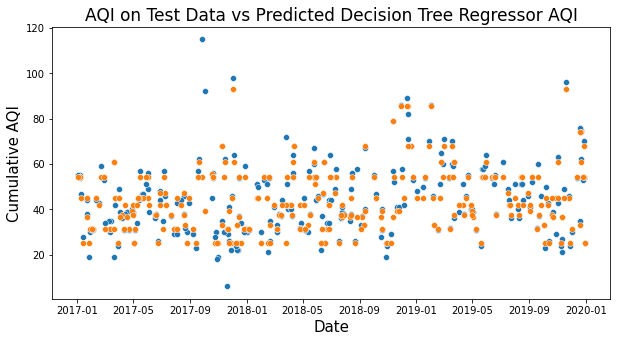

In [64]:
plt.subplots(figsize = (10,5))
plt.title('AQI on Test Data vs Predicted Decision Tree Regressor AQI', fontsize = 17)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Cumulative AQI', fontsize = 15)
sns.scatterplot(x = y_test.index, y = y_test);
sns.scatterplot(x = y_test.index, y = pred13);

Test AQI values in blue align very well with the predicted aqi values displayed in orange from our model